In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import f1_score
import glob

In [6]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [7]:
# Normal dataset
#df = pd.read_csv('CSVFiles/smallDomainDataBertweetEmbedded.csv')
#df = pd.read_csv('CSVFiles/small10000DomainDataBertweetEmbedded.csv')
df = pd.read_csv('CSVFiles/small50000DomainDataBertweetEmbedded.csv')
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

In [8]:
# Updating values for training_data
training_data = df[df['split'] == 'train']

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']

In [9]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples validation data: ', sum(validation_data['toxicity']))
print('None-toxic samples validation data: ', len(validation_data['toxicity'])-sum(validation_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  22010.0
None-toxic samples training data:  22010.0


Toxic samples validation data:  1510.0
None-toxic samples validation data:  1510.0


Toxic samples test data:  1510.0
None-toxic samples test data:  1510.0


male: 4567.0
female: 5272.0
LGBTQ: 1652.0
christian: 2300.0
muslim: 2332.0
other_religion: 20.0
black: 2475.0
white: 3818.0


In [10]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)
    
def CreatePlot(trainArr, valArr, path):
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r', label='Training loss')
    plt.scatter(np.arange(0,len(valArr)), valArr, color='g', label='Validation loss')
    plt.title("Training loss vs Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig(path, bbox_inches='tight')
    plt.show()

In [11]:
### Set parameters for the model
torch.manual_seed(1) # set fixed random seed for reproducibility
cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [12]:
# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())
    
prepare_testloader = []
for i in range(len(X_test)):
    prepare_testloader.append([X_test[i], Y_test[i]])
    
prepare_validloader = []
for i in range(len(X_val)):
    prepare_validloader.append([X_val[i], Y_val[i]])

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(768, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [14]:
def Train(model, train_loader, valid_loader, loss_function, optimizer, learning_rate, early_stopping=50, epochs=1000):
    
    # Setting up model parameters
    model = model.to(device)
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    if optimizer == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    loss_function = loss_function

    # Initialising early stopping criterias
    early_stopping = early_stopping
    notImproved = 0
    
    bestLoss = None
    bestModel = None

    trainArr = []
    valArr = []

    bestf1 = 0
    bestEpoch = 0

    for epoch in range(1, epochs + 1):
    
        train_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
        
            # get the input
            inputs, labels = data
    
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
        
            optimizer.zero_grad()
        
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
        
            loss = loss_function(outputs, labels)
        
            loss.backward()
        
            optimizer.step()
        
            train_loss += loss.item()
    
        train_loss /= len(train_loader.dataset)    
        trainArr.append(train_loss)
    
        valid_loss = 0
        labs = []
        preds = []
        
        model.eval()
        with torch.no_grad():        
            for batch_idx, data in enumerate(valid_loader):
                # get the input
                inputs, labels = data           
            
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                
                outputs = model(inputs).squeeze()
                
                labs.extend(labels)
                preds.extend(torch.round(outputs))
            
                valid_loss += loss_function(outputs, labels).item()
        
        valid_loss /= len(valid_loader.dataset)    
        valArr.append(valid_loss)
        
        if bestLoss == None:
            bestLoss = valid_loss
    
        if valid_loss <= bestLoss:
            bestModel = torch.save(model, 'currentModel.pth')
            bestLoss = valid_loss
            notImproved = 0
            bestEpoch = epoch
        else:
            notImproved +=1
        
        if notImproved >= early_stopping:
            break

    model = torch.load('currentModel.pth')
    return model, valArr, trainArr, epoch

0.301010101010101


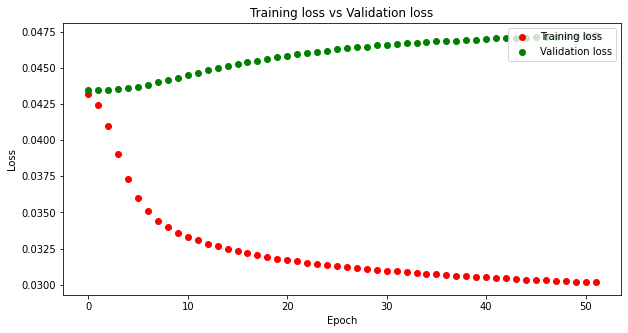

Accuracy on validation set:  0.5
Val f1: =  0.6666666666666666
Test f1: =  0.6666666666666666
Accuracy on test set:  0.5
0.1


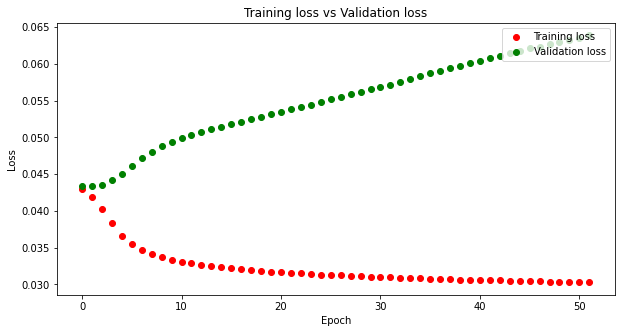

Accuracy on validation set:  0.5049668874172185
Val f1: =  0.6645725824545657
Test f1: =  0.6672645739910315
Accuracy on test set:  0.5086092715231788


In [20]:
epsilons = []
pathArr = []

for filePath in glob.glob('PCAmodels50000/*'):
    pathArr.append(filePath)
    epsilons.append(filePath[16:-4].replace(',', '.'))

epsilons = np.array(epsilons, dtype=float)
pathArr = np.array(pathArr)

# sort by epsilons
sortedIndexes = np.argsort(epsilons)
epsilons = epsilons[sortedIndexes]
pathArr = pathArr[sortedIndexes]

epsilons = np.flip(epsilons)
pathArr = np.flip(pathArr)

for i, path in enumerate(pathArr):
    print(epsilons[i])
    PCAmodel = torch.load(path)
    transformedXTrain = PCAmodel.transform(X_train)
    
    prepare_trainloader = []
    for i in range(len(X_train)):
        prepare_trainloader.append([transformedXTrain[i], Y_train[i]])
    
    train_loader = torch.utils.data.DataLoader(prepare_trainloader, batch_size=16, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(prepare_validloader, batch_size=16, shuffle=False)
    test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=16, shuffle=False)
        
    model, valLossArr , trainLossArr, epoch = Train(Net(), train_loader, valid_loader, nn.BCELoss(), 'AdamW', 0.00001, early_stopping=50, epochs=5000)
    
    CreatePlot(trainLossArr, valLossArr, 'PrivateModels50000/img' + path[16:-4]+ '.png')
    torch.save(model, 'PrivateModels50000/private' + path[16:])
    
    labs = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(valid_loader):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            outputs = model(inputs).squeeze()
            labs.extend(labels)
            preds.extend(torch.round(outputs))
    accVal = CheckAccuracy(labs, preds)
    print("Accuracy on validation set: ", accVal)
    f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
    print("Val f1: = ", f1)
    
    labs = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            outputs = model(inputs).squeeze()
            labs.extend(labels)
            preds.extend(torch.round(outputs))
    accTest = CheckAccuracy(labs, preds)
    f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
    print("Test f1: = ", f1)
    print("Accuracy on test set: ", accTest)

In [54]:
def F1_Scores(preds, labels):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i in range(len(labs)):
        if labels[i]==1 and preds[i]==1:
            true_positives += 1
        if labels[i]==0 and preds[i]==0:
            true_negatives += 1
        if labels[i]==0 and preds[i]==1:
            false_positives += 1
        if labels[i]==1 and preds[i]==0:
            false_negatives += 1
    print("true_positives", true_positives)
    print("true_negatives", true_negatives)
    print("false_positives", false_positives)
    print("false_negatives", false_negatives)
    
    return true_positives, true_negatives, false_positives, false_negatives

In [56]:
labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(test_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))

print("\n")        
print("Accuracy on test set: ", CheckAccuracy(labs, preds))
f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score test: ", f1)
true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(valid_loader):
        # get the input
        inputs, labels = data
        
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))

print("\n")
print("Accuracy on validation set: ", CheckAccuracy(labs, preds))
f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score val: ", f1)
true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(train_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("\n")
print("Accuracy on train set: ", CheckAccuracy(labs, preds))
f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score train: ", f1)
true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)




Accuracy on test set:  0.5086092715231788
F1_score test:  0.6672645739910315
true_positives 1488
true_negatives 48
false_positives 1462
false_negatives 22


Accuracy on validation set:  0.5049668874172185
F1_score val:  0.6645725824545657
true_positives 1481
true_negatives 44
false_positives 1466
false_negatives 29


Accuracy on train set:  0.6961835529304862
F1_score train:  0.7202911281214706
true_positives 17220
true_negatives 13426
false_positives 8584
false_negatives 4790
